In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir('/content/drive/MyDrive/TextMining/final_project/')

# News articles fake/true classification with neural network embeddings


In [2]:
# import libraries
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from datetime import datetime
import re
import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorboard.plugins import projector

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="darkgrid")
palette = sns.set_palette('rocket')
pd.set_option('display.max_colwidth', 100)

SEED = 666

## Auxiliary functions

In [3]:
# date conversion functions
def string_to_date_true(string):
  date = datetime.strptime(string, "%B %d, %Y ")
  return date
  
def string_to_date_fake(string):
  date = datetime.strptime(string, "%d-%b-%y")
  return date

def cleanText(s):
    # finds and replaces multiple noisy characters from text
    # including emojis, hashtags and user mentions
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    s = s.replace(r'\n', ' ')
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "[url]", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "[url]", s)
    #s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    # custom removals
    s = re.sub(r'@[A-Za-z0-9_]+', "@usermention", s) # remove mentions
    #s = re.sub(r'#[A-Za-z0-9_]+', "#hashtag", s) # remove hashtags
    #s = re.sub(r':[^:]+','[emoji]',s) # remove demojized text
    return str(s)

## Load data

In [4]:
# load news files
docs_fake = pd.read_csv('./data/Fake.csv', encoding = "utf-8", engine='python')
print(docs_fake.shape)
docs_true = pd.read_csv('./data/True.csv', encoding = "utf-8", engine='python')
print(docs_true.shape)

#cleaning small issues with dataset format: date, corrupted rows, etc.
docs_fake = docs_fake.drop(docs_fake.iloc[:, 4:],axis = 1)
docs_fake = docs_fake.dropna(axis = 0)
docs_fake["length"] = docs_fake.apply(lambda x : len(x["date"]), axis = 1)
docs_fake["length_subj"] = docs_fake.apply(lambda x : len(x["subject"]), axis = 1)
docs_fake = docs_fake.loc[docs_fake["length"] <=9]
docs_fake = docs_fake.loc[docs_fake["length_subj"] <= 20]
docs_fake['text'] = [cleanText(text) for text in docs_fake['text']]
docs_true['text'] = [cleanText(text) for text in docs_true['text']]
docs_true["date"] = docs_true.apply(lambda x : string_to_date_true(x["date"]), axis = 1)
docs_fake["date"] = docs_fake.apply(lambda x : string_to_date_fake(x["date"]), axis = 1)

docs_fake['fake_flag'] = 1
docs_true['fake_flag'] = 0

docs_all = pd.concat([docs_fake, docs_true], axis=0)
print(docs_all.shape)
docs_all['article_length'] = [len(row) for row in docs_all['text']]
print(np.average(docs_all['article_length']))

(23502, 4)
(21417, 4)
(44867, 7)
2448.355249960996


In [5]:
# split the train and test data
x = np.array(docs_all.text)
y = np.array(docs_all.fake_flag)

x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.3, random_state=666)

## Set parameters

In [6]:
# set parameters for embedding neural network
embedding_dim = 32      # Embedding hidden units size
vocab_size = 10000      # Vocabulary size to use for the full embedding
padding_type = 'post'   # Padding type for embedding
trunc_type = 'post'     # Truncate type for embedding
max_length = 2500        # Max length of embedding sequence

In [7]:
# Set stop words and remove them from x_train and x_test
add_stopwords = ['000']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stopwords)

vectorizer = CountVectorizer(binary = True, decode_error = u'ignore', stop_words=stop_words)
word_tokenizer = vectorizer.build_tokenizer()

x_train_tokens = [word_tokenizer(sentence) for sentence in x_train]
for i in range(len(x_train_tokens)):
    x_train_tokens[i] = [word for word in x_train_tokens[i] if word not in stop_words]
    x_train_tokens[i] =' '.join(map(str,x_train_tokens[i]))

x_test_tokens = [word_tokenizer(sentence) for sentence in x_test]
for i in range(len(x_test_tokens)):
    x_test_tokens[i] = [word for word in x_test_tokens[i] if word not in stop_words]
    x_test_tokens[i] =' '.join(map(str,x_test_tokens[i]))

## Tokenizer

In [8]:
# Tokenize and create sequences for train dataset
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<oov>token")
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Tokenize and create sequences for test dataset
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Define architecture

In [9]:
# Define neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

display(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2500, 32)          320000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 324,353
Trainable params: 324,353
Non-trainable params: 0
__________________________________________________

None

## Run model

In [10]:
# define model parameters
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [11]:
# run model
model.fit(train_padded_sequences, y_train, epochs=10, validation_data=(test_padded_sequences, y_test))

Epoch 1/10
982/982 [==============================] - 18s 17ms/step - loss: 0.2996 - accuracy: 0.8755 - val_loss: 0.0827 - val_accuracy: 0.9868
Epoch 2/10
982/982 [==============================] - 18s 18ms/step - loss: 0.0629 - accuracy: 0.9863 - val_loss: 0.0421 - val_accuracy: 0.9921
Epoch 3/10
982/982 [==============================] - 18s 18ms/step - loss: 0.0338 - accuracy: 0.9938 - val_loss: 0.0266 - val_accuracy: 0.9946
Epoch 4/10
982/982 [==============================] - 17s 17ms/step - loss: 0.0195 - accuracy: 0.9968 - val_loss: 0.0200 - val_accuracy: 0.9961
Epoch 5/10
982/982 [==============================] - 17s 17ms/step - loss: 0.0140 - accuracy: 0.9975 - val_loss: 0.0173 - val_accuracy: 0.9962
Epoch 6/10
982/982 [==============================] - 17s 17ms/step - loss: 0.0082 - accuracy: 0.9986 - val_loss: 0.0166 - val_accuracy: 0.9964
Epoch 7/10
982/982 [==============================] - 17s 18ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0213 - val_accuracy:

## Results

In [12]:
# store loss and accuracy values for plotting
results = pd.DataFrame()
temp = pd.DataFrame()

epoch = model.history.epoch
train_loss = model.history.history["loss"]
test_loss = model.history.history["val_loss"]

train_acc = model.history.history["accuracy"]
test_acc = model.history.history["val_accuracy"]

temp['epoch'] = [item for item in epoch]
temp['phase'] = 'train'
temp['loss'] = [item for item in train_loss]
temp['accuracy'] = [item for item in train_acc]

results = results.append(temp)
results = results.reset_index()
results = results.drop('index', axis=1)

temp['epoch'] = [item for item in epoch]
temp['phase'] = 'test'
temp['loss'] = [item for item in test_loss]
temp['accuracy'] = [item for item in test_acc]

results = results.append(temp)
results = results.reset_index()
results = results.drop('index', axis=1)

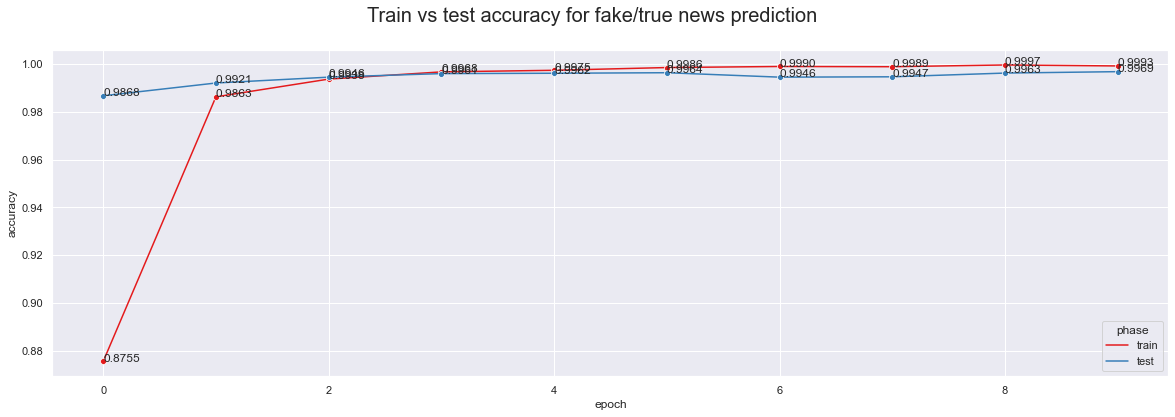

In [13]:
palette = sns.set_palette('Set1')
sns.set_style("darkgrid")
# plot train vs test accuracy
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test accuracy for fake/true news prediction', size=20)
sns.lineplot(data=results, x='epoch', y='accuracy', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results.iterrows():
    ax1.text(item['epoch'],item['accuracy'],f'{item.accuracy:.4f}');

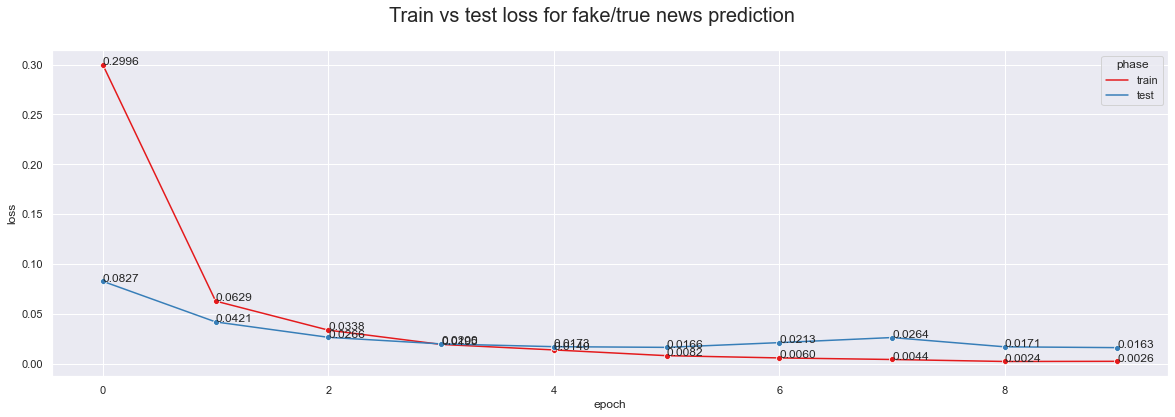

In [14]:
# plot train vs test loss
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test loss for fake/true news prediction', size=20)
sns.lineplot(data=results, x='epoch', y='loss', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results.iterrows():
    ax1.text(item['epoch'],item['loss'],f'{item.loss:.4f}');

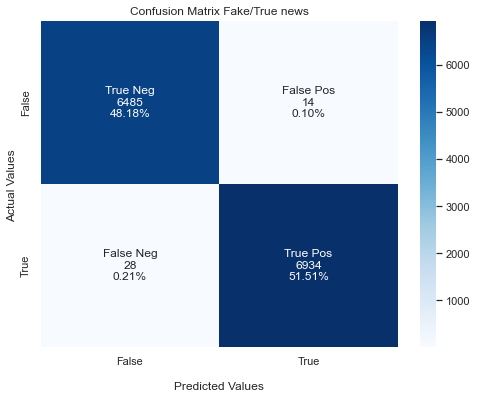

In [15]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_padded_sequences)
y_pred = [1 if item>0.5 else 0 for item in y_pred]

# get values for confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig1, ax1 = plt.subplots(figsize=(8, 6));
ax = sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix Fake/True news');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [16]:
# display misclassified articles
result = np.where(y_test!=y_pred)
result

(array([ 1250,  1401,  1486,  1688,  2219,  2259,  2467,  2685,  2764,
         3050,  3186,  3557,  3630,  3725,  4138,  4163,  4810,  5313,
         6091,  6232,  6848,  7027,  7211,  7946,  8312,  8971,  9007,
         9211,  9305,  9379,  9403,  9523,  9555,  9570, 10124, 10313,
        10375, 10473, 10879, 11497, 12374, 13324], dtype=int64),)

In [17]:
# see some examples of misclassified articles
index = result[0][0]
print('True value: {}, Predicted value: {}'.format(y_test[index],y_pred[index]))
print(x_test[index])

True value: 0, Predicted value: 1
NEW YORK (Reuters) - In April, Reuters photographer Zohra Bensemra was sent to cover the drought in Somalia. Once there, she looked for ways to humanize the plight of more than 2 million people trying to survive the famine amid fields of withered crops and the brittle skeletons of livestock.  See her portfolio of work here In a makeshift camp for displaced people, Bensemra met Zeinab, a 14-year-old girl forced to marry an older man offering $1,000 as her dowry. Zeinab had wanted to become an English teacher, but that small fortune made it possible for her extended family to travel to a Somali town on the Ethiopian border where international aid agencies providing food for drought refugees. Bensemra found similar stories during a nearly two-week trip through the Horn of Africa.  Photography opens eyes to what s going on in the world,  says Bensemra, who was named agency photographer of the year by the Guardian, a U.K.-based newspaper.  It s not about na

## Test on current news

In [18]:
import requests
from bs4 import BeautifulSoup
import os

root="http://lite.cnn.com"

#adapt to your system here
destination="./data/"

#code for the front page of the news article
response = requests.get("http://lite.cnn.com")
soup = BeautifulSoup(response.text, 'html.parser')

#to select each relevant URL - only want hyperlinks that have 'en/article in them'
root="http://lite.cnn.com"
urls = []
for r_link in soup.find_all('a'):
    if "/en/article/" in r_link['href']:
        #print(root+str(r_link['href']))
        urls.append(root+str(r_link['href']))

In [19]:
df_corpus_joined = pd.DataFrame({'title': np.nan, 'date': np.nan, 'time': np.nan, 'text': ''},index=[0])

for j in range(len(urls)):
    response = requests.get(urls[j])
    soup = BeautifulSoup(response.text, 'html.parser')
    art_title = soup.find('h2').text
    art_time = re.findall("[0-9][0-9][0-9] ([\s\S]*?) GMT", soup.find("p", id="published datetime").text)
    art_date = re.findall(", ([\s\S]*?) [0-9][0-9]+\:", soup.find("p", id="published datetime").text)
    
    #the first line of the news article always has an id tag of editorsNote
    row = soup.find('p', id = "editorsNote")
    mylist = []
    
    #the news article always ends with a copywrite symbol and Cable News Network
    while "Cable News Network" not in row.find_next('p').text:
        row = row.find_next('p')
        mylist.append(row.text)
    text="\n".join(mylist)
    row_corpus = pd.DataFrame({'title': art_title, 'date': art_date, 'time': art_time, 'text': text})
    df_corpus_joined = df_corpus_joined.append(row_corpus)

In [20]:
# print the number of articles scrapped and remove first entry which is noisy
print(len(df_corpus_joined))
scrapped_articles = df_corpus_joined[1:]

96


In [21]:
# set our x for the scrapped dataset for later prediction
scrapped_x = scrapped_articles['text']
scrapped_x

0    Russia has doubled down on its threat to cut off natural gas supplies to Western countries that ...
0    The US and its allies have been weighing how the West could provide Ukraine with alternative sec...
0    Russian forces have withdrawn from Chernobyl, the site of the world's worst nuclear disaster, th...
0    A 12-year-old student was fatally shot by a classmate at a South Carolina middle school, officia...
0    Florida Gov. Ron DeSantis on Thursday signaled support for stripping Disney of its 55-year-old s...
                                                    ...                                                 
0    Last week's announcement that Moderna plans to seek authorization of its Covid-19 vaccine for yo...
0    The torrential downpour that greeted Will and Kate in the Bahamas on Friday was the perfectly fi...
0    As the 2022 primary season gets underway, those of us who have long opposed former President Don...
0    Why has Russian President Vladimir Putin taken tim

In [22]:
# tokenize and create sequences for scrapped dataset
cnn_sequences = tokenizer.texts_to_sequences(scrapped_x)
cnn_padded_sequences = pad_sequences(cnn_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [23]:
# run prediction on scrapped dataset
cnn_ypred = model.predict(cnn_padded_sequences)

In [24]:
# extract percentage of articles marked as fake from scrapped dataset
cnn_fake_index = np.where(cnn_ypred==1)[0]
print(len(cnn_fake_index)/len(scrapped_articles))
cnn_fake_index

0.30526315789473685


array([ 5,  9, 10, 12, 13, 15, 17, 20, 22, 23, 31, 32, 34, 40, 45, 46, 47,
       48, 64, 66, 70, 74, 80, 81, 84, 90, 92, 93, 94], dtype=int64)

In [25]:
# see example of articles marked as fake from scrapped dataset
index = cnn_fake_index[0]
scrapped_articles.iloc[index]['text']

'On Tuesday, the US Food and Drug Administration expanded its authorization of the Pfizer/BioNTech and Moderna Covid-19 vaccines. Now, adults ages 50 and older are able to get a second booster if at least four months have passed since their first one.\nWithin hours, the US Centers for Disease Control and Prevention came out with a statement that says it will also allow second boosters as well as guidance for people who initially received the Johnson & Johnson vaccine. These individuals who subsequently got a booster are now eligible for a second booster shot, too.\nAll these developments come in the wake of the CDC\'s updated analysis showing that the highly transmissible BA.2 subvariant is the dominant strain in the United States.\nNow that more people can receive an additional vaccine dose, should they get it? What are factors they might want to consider? Is there any downside to getting more shots? And does it make sense to wait until a big event such as international travel or a la

## Test on multiple news sources

In [26]:
# load data for multiple sources news articles
articles1 = pd.read_csv('./data/articles1.csv')
articles2 = pd.read_csv('./data/articles2.csv')
articles3 = pd.read_csv('./data/articles3.csv')

# perform some clean up tasks
articles = pd.concat([articles1, articles2, articles3])
articles=articles.dropna(subset=['date']).reset_index(drop=True)
articles['length'] = [len(str(item)) for item in articles.date]

display(articles.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139929 entries, 0 to 139928
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   139929 non-null  int64  
 1   id           139929 non-null  int64  
 2   title        139927 non-null  object 
 3   publication  139929 non-null  object 
 4   author       125011 non-null  object 
 5   date         139929 non-null  object 
 6   year         139929 non-null  float64
 7   month        139929 non-null  float64
 8   url          82920 non-null   object 
 9   content      139929 non-null  object 
 10  length       139929 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 11.7+ MB


None

In [27]:
articles[:5]

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,length
0,0,17283,House Republicans Fret About Winning Their Health Care Suit - The New York Times,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have a new fear when it comes to their health care ...,10
1,1,17284,Rift Between Officers and Residents as Killings Persist in South Bronx - The New York Times,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood dries and the votive candles burn out, people pee...",10
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial Bias, Dies at 106 - The New York Times",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, critics praised its spare, haunting visual style, vas...",10
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Music - The New York Times",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t necessarily evenhanded. Of all the fields of ende...",10
4,4,17287,Kim Jong-un Says North Korea Is Preparing to Test Long-Range Missile - The New York Times,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, Kim said on Sunday that his country was making f...",10


In [28]:
# function that will tokenize and run predictions
def get_fake_index(tag, model, data):
    data = data[data.publication == tag]
    filtered_data = data
    data = data.content
    length = len(data.content)

    sequences = tokenizer.texts_to_sequences(data)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    ypred = model.predict(padded_sequences)

    fake_index = np.where(ypred==1)[0]
    original_ids = [filtered_data.iloc[index].id for index in fake_index]
    pctg_idxs = len(fake_index)/len(data)
    
    return {'source':tag, 'fake_score':pctg_idxs, 'fake_idxs':list(fake_index), 'original_idxs':list(original_ids), 'length':length}

In [29]:
# get all sources in a list
sources = articles.publication.unique()

In [30]:
# run prediction through all the sources
results_mult = pd.DataFrame(columns=['source','fake_idxs','fake_score','original_idxs', 'length'])

for source in sources:
    dict = get_fake_index(source, model, articles)
    print(source, dict['length'])
    results_mult = results_mult.append(dict, ignore_index=True)

New York Times
Breitbart
CNN
Business Insider
Atlantic
Fox News
Talking Points Memo
Buzzfeed News
National Review
New York Post
Guardian
NPR
Reuters
Vox
Washington Post


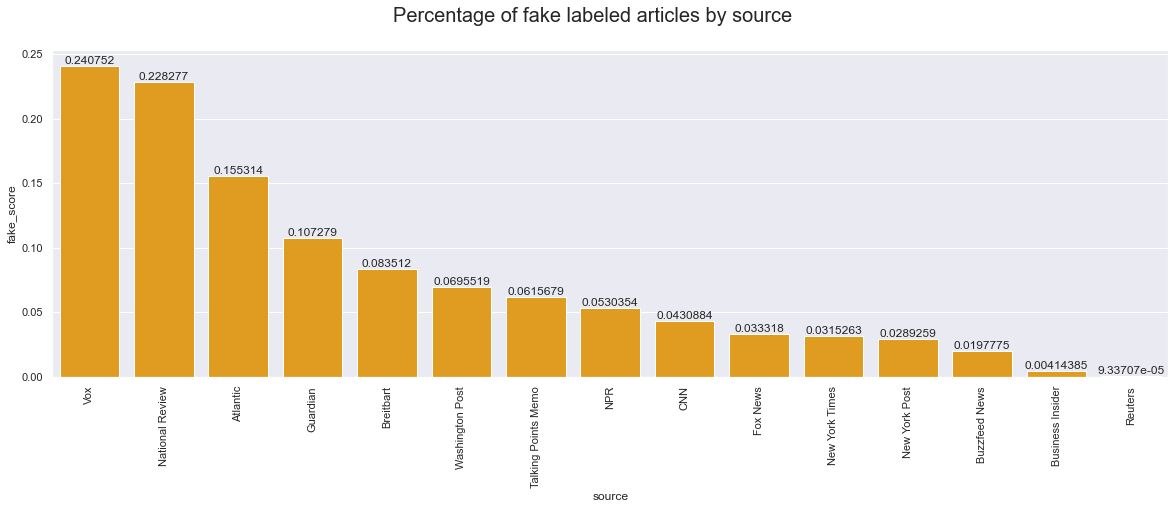

In [31]:
# plot resulst from fake predicition scoring by source
palette = sns.set_palette('Blues')
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Percentage of fake labeled articles by source', size=20)

order = results_mult.groupby('source')['fake_score'].sum().sort_values(ascending=False).index.values

g = sns.barplot(data=results_mult, x='source', y='fake_score', order=order, color='orange')
ax1.tick_params(axis='x', rotation=90)

g.bar_label(g.containers[0]);

In [32]:
# examples of article news marked as fake
pd.set_option('display.max_colwidth', 300)

display(articles[['content']][articles.id==list(results_mult[results_mult.source=='Breitbart']['original_idxs'])[0][0]])
display(articles[['content']][articles.id==list(results_mult[results_mult.source=='National Review']['original_idxs'])[0][0]])
display(articles[['content']][articles.id==list(results_mult[results_mult.source=='New York Times']['original_idxs'])[0][0]])

,content
7814,"Two helicopters, an FBI bomb squad and riot police have been deployed at the University of Washington to control violent protesters before one of MILO’s final talks of the ‘Dangerous Faggot Tour. ’[As has been seen throughout the door, the protests have quickly turned violent, with protesters ..."


,content
68829,"It was the key debate of the 2016 election. Donald Trump won the election, in no small part, because he appeared to be on the right side of it. Appeared is used advisedly: Trump was at least in the general vicinity of the bull’ his opponent wouldn’t even acknowledge the target existed — ex..."


,content
10,"With Donald J. Trump about to take control of the White House, it would seem a dark time for the renewable energy industry. After all, Mr. Trump has mocked the science of global warming as a Chinese hoax, threatened to kill a global deal on climate change and promised to restore the coal industr..."


## Bonus - Embedding visualization

In [33]:
from tensorflow.keras.layers import TextVectorization
import re
import string

# create tensorflow dataset based on our train data
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))

In [34]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 2500

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = dataset.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [35]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [36]:
wordindex_dict = tokenizer.word_index

In [56]:
%reload_ext tensorboard

In [57]:
# create logging directory
log_dir='./logs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# write wordindex dictionary
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for w in wordindex_dict:
    f.write("{}\n".format(w))

# weights from the embedding layer, in our case: model.layers[1]
#weights = tf.Variable(model.layers[1].get_weights()[0][1:])
weights = tf.Variable(model.get_layer('embedding').get_weights()[0])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, 'embedding.ckpt'))

# configuration set-up
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = 'embedding/.ATTRIBUTES/VARIABLE_VALUE'
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [59]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 4936), started 0:19:39 ago. (Use '!kill 4936' to kill it.)